# Heisenberg's uncertainty principle

## 1. Background

### 1.1 Uncertainty relation between position and momentum

Heisenberg's uncertainty principle is a very famous principle in quantum mechanics, which was first proposed by Heisenberg in 1927. The uncertainty principle states that the more precisely the position of some particle is determined, the less precisely its momentum can be predicted from initial conditions, and vice versa. In fact this principle has nothing to do with the experimental level of measurement, but is determined by the commutator of the position operator and the momentum operator, and its mathematical expression is $\Delta x \Delta p \geq \frac{\hbar}{2}$. In addition, the uncertainty principle can be generalized to any two hermitian operators.

### 1.2 General uncertainty principle

Let A and B be two hermitian operators (i.e. $A=A^\dagger$, $B=B^\dagger$), and $\langle A \rangle$ be the expectation value of A in a given normalized state $|\psi\rangle$. We define the uncertainty of A as:
$$ \Delta A=\langle (A - \langle A \rangle )^2 \rangle ^{1/2}=
( \langle A^2 \rangle - \langle A \rangle^2 ) ^{1/2}.$$
Similarly, we can define the expectation value of B and its uncertainty. It can be shown that
$$\Delta A \Delta B \geq \frac{1}{2} |\langle [A,B] \rangle|. $$
This is the general uncertainty principle, where $[A,B]=AB-BA$ is the commutator of $A$ and $B$.  
For the position operator $x$ and the momentum operator $p$, their commutator is $[x,p]=i \hbar$, thus $\Delta x \Delta p \geq \frac{1}{2} |\langle [x,p] \rangle| = \frac{\hbar}{2}$. This is the uncertainty relation between position and momentum.

### 1.3 Uncertainty relation between $\sigma_X$ and $\sigma_Y $

Three quantum logic gates $X$,$Y$,$Z$ correspond to three  Pauli matrices $\sigma_X$,$\sigma_Y$,$\sigma_Z$ respectively, where $X=\begin{pmatrix} 0 & 1 \\ 1 & 0\end{pmatrix}$,$Y=\begin{pmatrix} 0 & -i \\ i & 0\end{pmatrix}$,$Z=\begin{pmatrix} 1 & 0 \\ 0 & -1\end{pmatrix}$. Since $[\sigma_X,\sigma_Y]=2i\sigma_Z$, according to the uncertainty principle, there should be $\Delta X \Delta Y \geq \ |\langle Z \rangle |. $  
More specifically, if the quantum state is set as $|\psi \rangle=cos \frac{\theta}{2}|0 \rangle + e^{i\phi}sin\frac{\theta}{2}|1 \rangle $, then it can be calculated that 
$$ \langle \psi |X| \psi \rangle = sin \theta cos \phi, \langle \psi |Y| \psi \rangle = sin \theta sin \phi, \langle \psi |Z| \psi \rangle = cos \theta , \langle \psi |X^2| \psi \rangle = \langle \psi |Y^2| \psi \rangle = 1,$$
$$ [ \Delta (X) \Delta (Y) ]^2-| \langle Z \rangle|^2=(1-{sin}^2 \theta {cos}^2 \phi)(1- {sin}^2 \theta {sin}^2 \phi)-{cos}^2 \theta={cos}^2 \phi {sin}^2 \phi {sin}^4 \theta \geq 0. $$
The above formula is the uncertainty relation between $\sigma_X$ and $\sigma_Y$ operators, and we will demonstrate it by pyquafu below.

## 2. The general idea of the demonstration

Construct a quantum circuit to rotate the qubits from $|0\rangle$ to $|\psi\rangle=\cos \frac{\theta}{2}|0\rangle + e^{i\phi}\sin\frac{\theta}{2}|1\rangle$. Rotate the measurement bases and measure the qubits in the eigenstates of $X$,$Y$,$Z$ operators respectively. Calculate the expectation values of the corresponding operators based on the measurement outcomes, and compute the value of $[\Delta (X) \Delta (Y)]^2-|\langle Z \rangle|^2$ (since $X^2=Y^2=I$, substitute $\langle X^2 \rangle=\langle Y^2 \rangle=1$ directly). If the result is greater than 0, it indicates that the uncertainty relation holds, and we can further compare it with the theoretical value. Change the values of $\theta$ and $\phi$, repeat the above steps, and demonstrate for different quantum states $|\psi\rangle$.

## 3. Code

### 3.1 Construct quantum circuits

Define a function to construct a 3-qubit circuit, which rotates every qubit from $|0\rangle$ to $|\psi\rangle=cos \frac{\theta}{2}|0\rangle + e^{i\phi}sin\frac{\theta}{2}|1\rangle $. To simplify the problem, we fixed $\phi$ as $\frac{\pi}{4}$ and $\theta$ as variable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from quafu import QuantumCircuit, simulate, Task
from numpy import pi, cos, sin

def construct_circuit(theta):
    qc = QuantumCircuit(3)
    for i in range(3):  # rotate the qubit: |0> --> |ψ> = cos(θ/2)|0> + exp(i*pi/4)*sin(θ/2)|1>
        if theta != 0:
            qc.ry(i, theta)
        qc.rz(i, pi/4)
    qc.barrier([0,1,2])
    qc.ry(0, -pi/2)   # change measure bases to the eigenstates of X
    qc.rx(1, pi/2)    # change measure bases to the eigenstates of Y
    qc.measure([0,1,2])
    return qc

Take $\theta = \frac{\pi}{2}$ as an example, plot the quantum circuit.

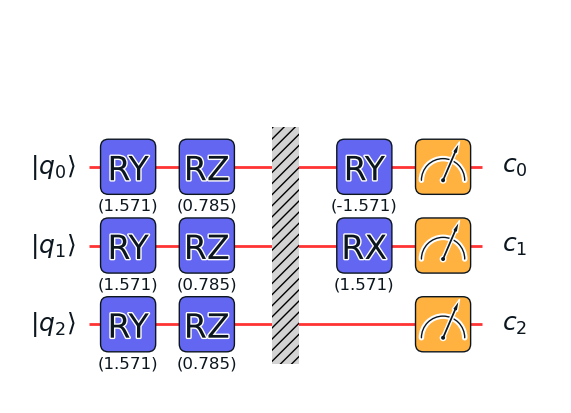

In [2]:
q = construct_circuit(pi/2)
q.plot_circuit()

### 3.2 Create tasks

Define a function to create the demonstration tasks. It has two parameters, `theta_num` and `experimental`. `theta_num` is used to determine how many values of $\theta$ to take, and `experimental` is used to choose whether to run on a real mechine or simulate with a simulator. The function will uniformly take `theta_num` values of $\theta$ in the interval $[0,\pi)$ and measure them, and put the expected values of $E(X)$, $E(Y)$, and $E(Z)$ in `obsexp`.

The function has three return parameters, `theta`, `obsexp`, and `experimental`, which represent the values of $\theta$ taken, the corresponding three expectations, and whether it runs on a real device or a simulator. In addition, if you choose to run on a real mechine, the function will display the `taskid` of the task, which you can save for later viewing.

In [3]:
def uncertainty_principle_demo(theta_num = 10, experimental: bool = False):
    theta_step=pi/theta_num  
    theta=[]  # to save the value of theta
    obsexp=[]  # to save the value of EX,EY,EZ
    name=["θ={:.3f}*pi".format(i*theta_step/pi)  for i in range(theta_num)]  # name of each task
    groupname="uncertainty_principle"  # name of group
    task = Task()  # create and configure task
    task.config(backend="ScQ-P18", shots=2000, compile=True) # backend can be "ScQ-P10", "ScQ-P18", "ScQ-P136"
    for i in range(theta_num):
        theta_i = i*theta_step
        qc = construct_circuit(theta = theta_i)
        sub_obsexp=[] # to save the value of EX,EY,EZ in this loop
        if experimental:
            sub_res = task.send(qc, name=name[i], group=groupname)
            for i in range(3):
                sub_obsexp.append(sub_res.calculate_obs([i]))
            print("θ= {:.3f}*pi ".format(theta_i/pi),"E(X) = {0:.5f}, E(Y) = {1:.5f}, E(Z) = {2:.5f}".format(*sub_obsexp))
        else:
            simu_res = simulate(qc)
            for i in range(3):
                sub_obsexp.append(simu_res.calculate_obs([i]))
        theta.append(theta_i)
        obsexp.append(sub_obsexp)
    if experimental:
        history=task.get_history()
        print("","taskid：",history,"",sep="\n")  # save the history to disk if you want to retrieve it next time
    return theta,obsexp,experimental

## 4. Show the result

To show the theoretical curve, we take 100 theta values uniformly in the interval $[0,\pi)$ and calculate its theoretical value.

In [4]:
def Theoretical_value(theta, phi=pi/4):
    return (sin(phi)**2)*(cos(phi)**2)*(sin(theta)**4)  # [Δ(X)Δ(Y)]^2-|<Z>|^2
x = np.linspace(0, pi, 100)
y = Theoretical_value(x)

In [5]:
def Plot_theoretical_value(x,y):
    plt.plot(x, y, label="Theoretical value: sin(φ)^2*cos(φ)^2*sin(θ)^4")
    plt.xlabel("theta")
    plt.ylabel("(Δ(X)Δ(Y))^2-|<Z>|^2")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15))

### 4.1 Simulation result

By calling the `uncertainty_principle_demo` function and setting the `experimental` parameter to False, we can get results operating on the simulator, which can then be visualized with the method in matplotlib.

θ= 0.000*pi  [Δ(X)Δ(Y)]^2-|<Z>|^2 = 0.000000
θ= 0.100*pi  [Δ(X)Δ(Y)]^2-|<Z>|^2 = 0.002280
θ= 0.200*pi  [Δ(X)Δ(Y)]^2-|<Z>|^2 = 0.029841
θ= 0.300*pi  [Δ(X)Δ(Y)]^2-|<Z>|^2 = 0.107095
θ= 0.400*pi  [Δ(X)Δ(Y)]^2-|<Z>|^2 = 0.204534
θ= 0.500*pi  [Δ(X)Δ(Y)]^2-|<Z>|^2 = 0.250000
θ= 0.600*pi  [Δ(X)Δ(Y)]^2-|<Z>|^2 = 0.204534
θ= 0.700*pi  [Δ(X)Δ(Y)]^2-|<Z>|^2 = 0.107095
θ= 0.800*pi  [Δ(X)Δ(Y)]^2-|<Z>|^2 = 0.029841
θ= 0.900*pi  [Δ(X)Δ(Y)]^2-|<Z>|^2 = 0.002280


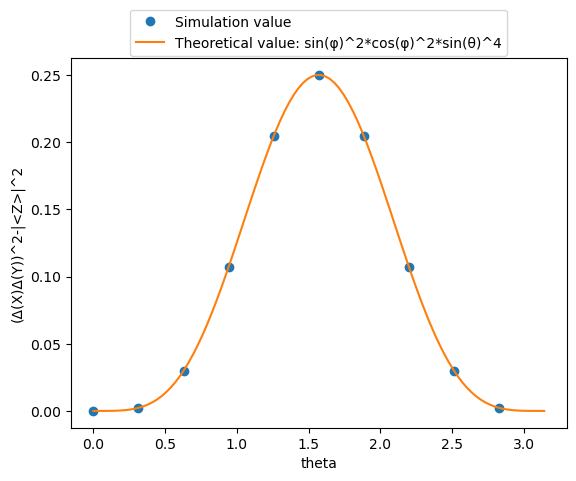

In [6]:
theta, obsexp, experimental = uncertainty_principle_demo(theta_num = 10, experimental = False)
res=[(1-obsexp[i][0]**2)*(1-obsexp[i][1]**2)-obsexp[i][2]**2 for i in range(len(obsexp))]  # [Δ(X)Δ(Y)]^2-|<Z>|^2
for i in range(len(res)):
    print("θ= {:.3f}*pi ".format(theta[i]/pi),"[Δ(X)Δ(Y)]^2-|<Z>|^2 = {:.6f}".format(res[i]))  # show the result data
# show the result graph
plt.plot(theta, res, "o",label="Simulation value")
Plot_theoretical_value(x,y)
plt.show()

### 4.2 Experimental result

By setting the `experimental` parameter to True, we can get results running on the real machine. And the history of the task will be shown.

θ= 0.000*pi  E(X) = 0.00900, E(Y) = 0.02400, E(Z) = 0.98900
θ= 0.100*pi  E(X) = 0.22400, E(Y) = 0.27200, E(Z) = 0.95600
θ= 0.200*pi  E(X) = 0.41200, E(Y) = 0.37800, E(Z) = 0.80100
θ= 0.300*pi  E(X) = 0.54000, E(Y) = 0.52800, E(Z) = 0.60000
θ= 0.400*pi  E(X) = 0.63400, E(Y) = 0.61400, E(Z) = 0.37800
θ= 0.500*pi  E(X) = 0.68000, E(Y) = 0.68400, E(Z) = 0.03300
θ= 0.600*pi  E(X) = 0.60600, E(Y) = 0.60600, E(Z) = -0.32700
θ= 0.700*pi  E(X) = 0.53900, E(Y) = 0.44100, E(Z) = -0.55700
θ= 0.800*pi  E(X) = 0.39900, E(Y) = 0.36700, E(Z) = -0.80600
θ= 0.900*pi  E(X) = 0.28100, E(Y) = 0.17600, E(Z) = -0.94300

taskid：
{'uncertainty_principle': ['310515002D5EC2E5', '310516A00ACDE264', '310518501F5B5417', '310519F035967D94', '31051CC00ECBA4B8', '31051F8022D3216E', '31052080396DEF4E', '3105218019B65A0A', '3105228028D39192', '31052390053B2067']}

θ=0.000*pi  [Δ(X)Δ(Y)]^2-|<Z>|^2 = 0.021222
θ=0.100*pi  [Δ(X)Δ(Y)]^2-|<Z>|^2 = -0.034384
θ=0.200*pi  [Δ(X)Δ(Y)]^2-|<Z>|^2 = 0.070025
θ=0.300*pi  [Δ(X)Δ(Y)]^2-

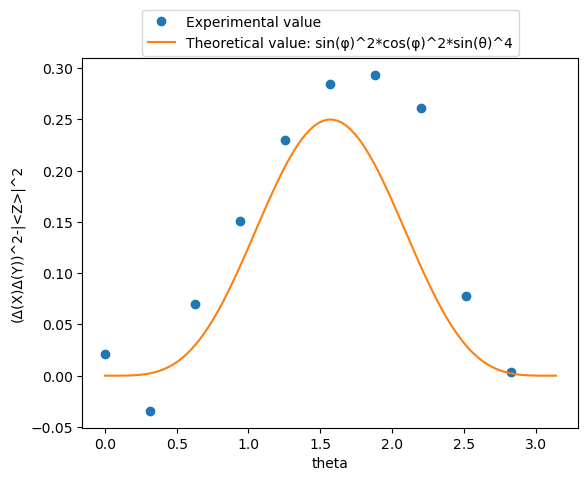

In [7]:
theta, obsexp, experimental = uncertainty_principle_demo(theta_num = 10, experimental = True)
res=[(1-obsexp[i][0]**2)*(1-obsexp[i][1]**2)-obsexp[i][2]**2 for i in range(len(obsexp))]  # [Δ(X)Δ(Y)]^2-|<Z>|^2
for i in range(len(res)):
    print("θ={:.3f}*pi ".format(theta[i]/pi),"[Δ(X)Δ(Y)]^2-|<Z>|^2 = {:.6f}".format(res[i]))  #show the result data
# show the result graph
plt.plot(theta, res, "o",label="Experimental value")
Plot_theoretical_value(x,y)
plt.show()